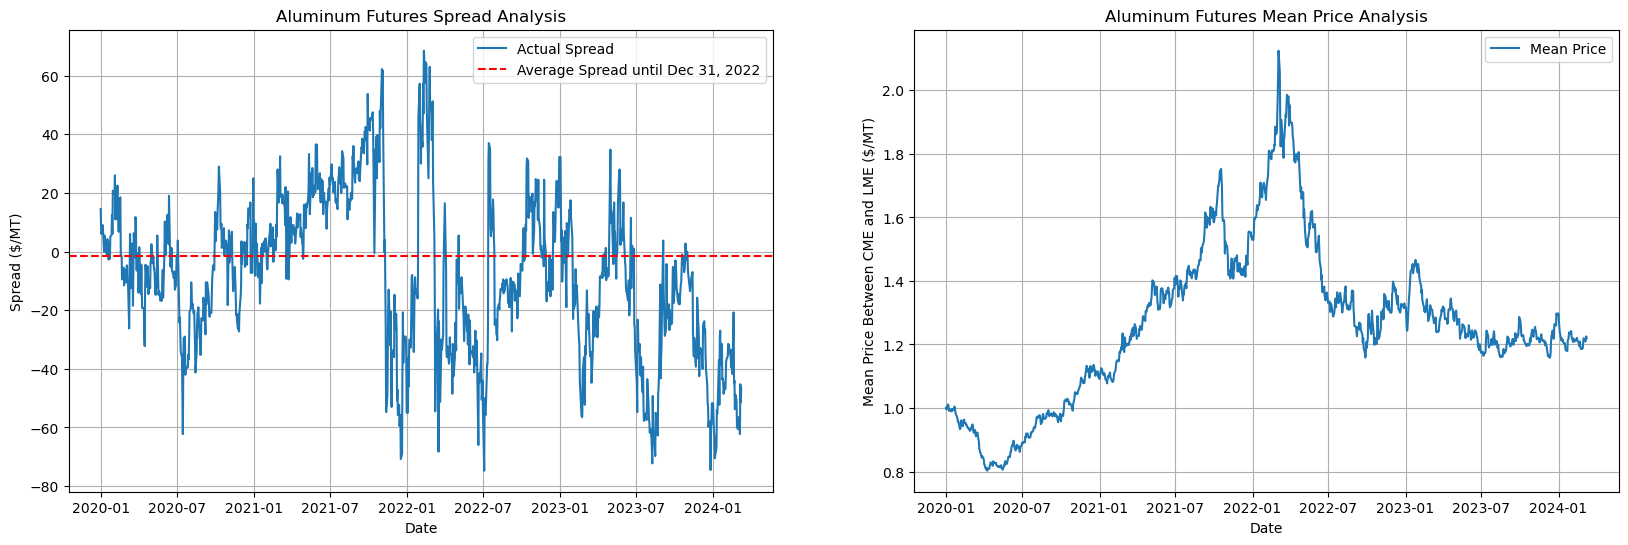

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
file_path = 'AL_raw.xlsx' 
copper_data = pd.read_excel(file_path)
copper_data['Dates'] = pd.to_datetime(copper_data['Dates'])

# Convert 'HGK4 Comdty' to $/MT
#pounds_to_metric_tons = 2204.62
#copper_data['HGK4 Comdty'] = (copper_data['HGK4 Comdty'] / 100) * pounds_to_metric_tons

# Calculate the spread
copper_data['Spread'] = copper_data['HGK4 Comdty'] - copper_data['LMCADS03 Comdty']


#Filter out single day spikes (noisy data): Calculate a 5-day centered rolling average and identify spikes
copper_data['Spread_5D_Mean'] = copper_data['Spread'].rolling(window=5, center=True).mean()
std_dev_multiplier = 1  # Define how many standard deviations constitute a significant change
copper_data['Spike'] = abs(copper_data['Spread'] - copper_data['Spread_5D_Mean']) > (copper_data['Spread'].std() * std_dev_multiplier)
copper_data = copper_data[~copper_data['Spike']]

# Splitting the data at December 31, 2022
cutoff_date = pd.Timestamp('2022-12-31')
pre_2023_data = copper_data[copper_data['Dates'] <= cutoff_date]
post_2022_data = copper_data[copper_data['Dates'] > cutoff_date]

# Calculate the average spread until December 31, 2022
average_spread_pre_2023 = pre_2023_data['Spread'].mean()

# Calculate the standarlized average price of copper 
copper_data["AVG_Price"] = (copper_data["HGK4 Comdty"]+copper_data["LMCADS03 Comdty"])/2
copper_data["STD_AVG_Price"] = copper_data["AVG_Price"]/copper_data.iloc[0]["AVG_Price"]

# Plotting
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.plot(copper_data['Dates'], copper_data['Spread'], label='Actual Spread')
plt.axhline(y=average_spread_pre_2023, color='r', linestyle='--', label='Average Spread until Dec 31, 2022')
plt.title('Aluminum Futures Spread Analysis')
plt.xlabel('Date')
plt.ylabel('Spread ($/MT)')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(copper_data['Dates'], copper_data['STD_AVG_Price'], label='Mean Price')

plt.title('Aluminum Futures Mean Price Analysis')
plt.xlabel('Date')
plt.ylabel('Mean Price Between CME and LME ($/MT)')
plt.legend()
plt.grid(True)

plt.show()


## Full data - with 90 day moving average

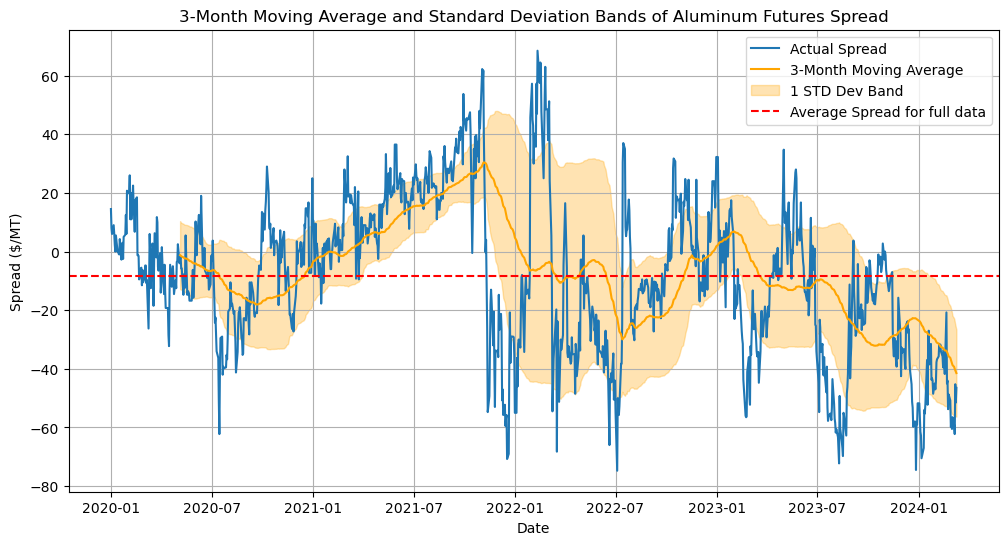

In [3]:
# Load the data
file_path = 'AL_raw.xlsx' 
copper_data = pd.read_excel(file_path)
copper_data['Dates'] = pd.to_datetime(copper_data['Dates'])

# Conversion for 'HGK4 Comdty' to $/MT
#pounds_to_metric_tons = 2204.62
#copper_data['HGK4 Comdty'] = (copper_data['HGK4 Comdty'] / 100) * pounds_to_metric_tons

# Create lag price for daily return
copper_data['HGK4_lag1'] = copper_data['HGK4 Comdty'].shift(1)
copper_data['LMCADS03_lag1'] = copper_data['LMCADS03 Comdty'].shift(1)

# Calculate the spread
copper_data['Spread'] = copper_data['HGK4 Comdty'] - copper_data['LMCADS03 Comdty']
average_spread = copper_data['Spread'].mean()


#Filter out single day spikes (noisy data): Calculate a 5-day centered rolling average and identify spikes
copper_data['Spread_5D_Mean'] = copper_data['Spread'].rolling(window=5, center=True).mean()
std_dev_multiplier = 1  # Define how many standard deviations constitute a significant change
copper_data['Spike'] = abs(copper_data['Spread'] - copper_data['Spread_5D_Mean']) > (copper_data['Spread'].std() * std_dev_multiplier)
copper_data = copper_data[~copper_data['Spike']]

# Calculate the 3-month moving average and standard deviation of the spread without spikes
window_size = 90  # Adjust based on the data frequency
copper_data['3M_MA_Spread'] = copper_data['Spread'].rolling(window=window_size).mean()
copper_data['3M_STD_Spread'] = copper_data['Spread'].rolling(window=window_size).std()

# Calculate the upper and lower bands
copper_data['Upper_Band'] = copper_data['3M_MA_Spread'] + 1*copper_data['3M_STD_Spread']
copper_data['Lower_Band'] = copper_data['3M_MA_Spread'] - 1*copper_data['3M_STD_Spread']

# Calculate the standarlized average price of copper 
copper_data["AVG_Price"] = (copper_data["HGK4 Comdty"]+copper_data["LMCADS03 Comdty"])/2
copper_data["STD_AVG_Price"] = copper_data["AVG_Price"]/copper_data.iloc[0]["AVG_Price"]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(copper_data['Dates'], copper_data['Spread'], label='Actual Spread')
plt.plot(copper_data['Dates'], copper_data['3M_MA_Spread'], label='3-Month Moving Average', color='orange')
plt.fill_between(copper_data['Dates'], copper_data['Upper_Band'], copper_data['Lower_Band'], color='orange', alpha=0.3, label='1 STD Dev Band')
plt.axhline(y=average_spread, color='r', linestyle='--', label='Average Spread for full data')
plt.title('3-Month Moving Average and Standard Deviation Bands of Aluminum Futures Spread')
plt.xlabel('Date')
plt.ylabel('Spread ($/MT)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
average_spread

-8.293229643183897

## Strategy

*Go short HGK4 and long LMCADS03 when spread (HGK4 - LMCADS03) increase to more than 1 std dev above 90 day moving averege of spread : direction = -1

*Go long HGK4 and short LMCADS03 when spread (HGK4 - LMCADS03) decrease to lower than 1 std dev below 90 day moving averege of spread : direction = +1.


*Close the position when

---the sign of moving average reverses 


---15 day passes

*Return is calculated on each trade = (upmove % on long - upmove % on short) * leverage

*inherent Leverage = 2 times: i.e. for 100USD invested, we can take exposure of 200USD (long + short)


In [5]:
# Functions for open and clsoe
def OpenPosition(date, row, direction,leverage):
    position_open = {
                'entry_date': date,
                'entry_hgk4': row['HGK4 Comdty'],
                'entry_lmcads03': row['LMCADS03 Comdty'],
                'direction': direction,  # HGK4 is overvalued so short it and long LMCADS03:  think shorting the spread as it should reduce 
            }
    return position_open

def ClosePosition(date, row, position_open, positions,leverage):
    exit_hgk4 = row['HGK4 Comdty']
    exit_lmcads03 = row['LMCADS03 Comdty']
    #percent_return = ((exit_hgk4 - position_open['entry_hgk4']) / position_open['entry_hgk4'] -(exit_lmcads03 - position_open['entry_lmcads03']) / position_open['entry_lmcads03']) * leverage * position_open['direction']
    #day_holding = (date - position_open['entry_date']).days
    #daily_return = np.exp(percent_return/day_holding)-1
    position_open.update({
        'exit_date': date,
        'exit_hgk4': exit_hgk4,
        'exit_lmcads03': exit_lmcads03,
        #'percent_return': percent_return,
        #'daily_return': daily_return
    })
    positions.append(position_open)
    position_open = None  # Close the position
    return position_open, positions


In [6]:
OBFR_df = pd.read_csv("OBFR.csv")
OBFR_df["Date"] = pd.to_datetime(OBFR_df["Date"])
OBFR_df.columns = ["Dates","OBFR"]
copper_data = copper_data.merge(OBFR_df, on = "Dates", how="left")
copper_data["OBFR"] = copper_data["OBFR"].fillna(method="ffill")
#copper_data

In [7]:
copper_data["OBFR"] = copper_data["OBFR"]/100/365

In [8]:
# Define the initial capital and leverage
initial_investment = 100
leverage = 1

# Calculate the 90-day moving average and standard deviation of the spread
window_size = 90
copper_data['MA_Spread'] = copper_data['Spread'].rolling(window=window_size).mean()
copper_data['STD_Spread'] = copper_data['Spread'].rolling(window=window_size).std()

# Define minimum and maximum holding period days
maximum_holding_period = 15  # Days
minimum_holding_period = 4 # Days

# Initialize a list to keep track of trades
positions = []
position_open = None  # Keeps track of whether there is an open position
daily_return = []

# Iterate through the data to check for trade signals
for index, row in copper_data.iterrows():
    date = row['Dates']
    current_spread = row['Spread']
    ma_spread = row['MA_Spread']
    std_spread = row['STD_Spread']
    
    # Update daily return if there is position
    if position_open:
        HDK4_cur = row['HGK4 Comdty']
        LMCADS03_cur = row['LMCADS03 Comdty']
        HDK4_lag1 = row['HGK4_lag1']
        LMCADS03_lag1 = row['LMCADS03_lag1']
        daily_return_val = ((HDK4_cur - HDK4_lag1) / HDK4_lag1 -(LMCADS03_cur - LMCADS03_lag1) / LMCADS03_lag1) * leverage * position_open['direction']
        daily_return.append(daily_return_val)

    else:
        daily_return.append(row["OBFR"])
    
    # Close the current position if conditions are met
    if position_open and (date - position_open['entry_date']).days >= minimum_holding_period: 
        if ((date - position_open['entry_date']).days >= maximum_holding_period or \
            (position_open['direction'] == 1 and current_spread < ma_spread) or \
            (position_open['direction'] == -1 and current_spread > ma_spread)):
            # Calculate percentage return for the position
            position_open,position = ClosePosition(date, row, position_open, positions,leverage)

    # Check for new entry signals if there is no open position
    if position_open is None :
        if current_spread > ma_spread + std_spread:
            # Open a positive spread position (short HGK4, long LMCADS03)
            position_open = OpenPosition(date, row, -1,leverage)

        elif current_spread < ma_spread - std_spread:
            # Open a negative spread position (long HGK4, short LMCADS03)
            position_open = OpenPosition(date, row, 1,leverage)
            

        
# Finalize any open positions at the end of the data
if position_open:
    last_row = copper_data.iloc[-1]
    date = last_row['Dates']
    position_open, positions = ClosePosition(date, row, position_open, positions)

# Convert the positions list to a DataFrame for easier analysis
positions_df = pd.DataFrame(positions)

# Display the positions DataFrame
positions_df

,entry_date,entry_hgk4,entry_lmcads03,direction,exit_date,exit_hgk4,exit_lmcads03
0,2020-05-11,1482.75,1497.5,1,2020-05-18,1481.25,1496.0
1,2020-05-18,1481.25,1496.0,1,2020-05-22,1489.75,1506.5
2,2020-05-22,1489.75,1506.5,1,2020-05-26,1502.75,1519.5
3,2020-05-26,1502.75,1519.5,1,2020-06-10,1633.00,1627.5
4,2020-06-12,1604.00,1585.0,-1,2020-06-16,1593.50,1597.5
...,...,...,...,...,...,...,...
143,2024-01-09,2182.50,2249.5,1,2024-01-15,2167.50,2204.5
144,2024-01-16,2161.75,2214.0,1,2024-01-22,2127.50,2159.0
145,2024-02-22,2144.25,2198.0,1,2024-02-26,2129.25,2180.0
146,2024-02-27,2131.75,2191.5,1,2024-03-04,2174.75,2234.0


## Plotting the cumulative portfolio movement

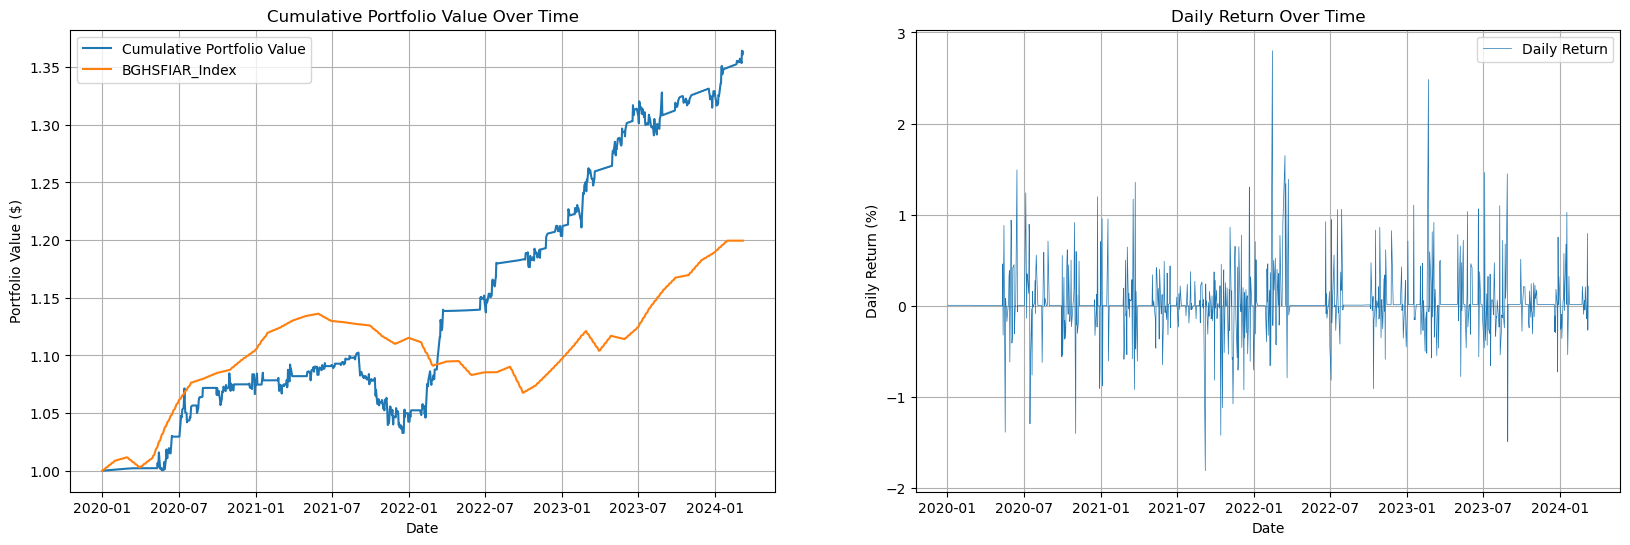

In [9]:
# Assuming initial investment of $1M
initial_investment = 1e6
portfolio_value = initial_investment
cumulative_values = [initial_investment]

# Compute cumulative return
copper_data["Daily Return"] = daily_return
copper_data["STD_Cumulative_Return"] = (1+copper_data["Daily Return"]).cumprod()
copper_data["Cumulative_Return"] = copper_data["STD_Cumulative_Return"] *initial_investment
copper_data["BHSTA Index"] = copper_data["BHSTA Index"].interpolate(method = "linear",axis = 0)
copper_data["STD_BHSTA_Index"] = copper_data["BHSTA Index"]/(copper_data.iloc[0]["BHSTA Index"])
copper_data["BGHSFIAR Index"] = copper_data["BGHSFIAR Index"].interpolate(method = "linear",axis = 0)
copper_data["STD_BGHSFIAR_Index"] = copper_data["BGHSFIAR Index"]/(copper_data.iloc[0]["BGHSFIAR Index"])

def plot_cum_value(positions_df,copper_data,initial_investment):
    plt.figure(figsize=(20, 6))
    
    plt.subplot(1,2,1)
    plt.plot(copper_data['Dates'], copper_data['STD_Cumulative_Return'], label='Cumulative Portfolio Value')
    #plt.plot(copper_data['Dates'], copper_data['STD_BHSTA_Index'], label='BHSTA_Index')
    plt.plot(copper_data['Dates'], copper_data['STD_BGHSFIAR_Index'], label='BGHSFIAR_Index')
    plt.title('Cumulative Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(copper_data['Dates'], copper_data['Daily Return']*100, label='Daily Return',lw = 0.5)
    plt.title('Daily Return Over Time')
    plt.xlabel('Date')
    plt.ylabel('Daily Return (%)')
    plt.legend()
    plt.grid(True)
  
    plt.show()
    

plot_cum_value(positions_df,copper_data,initial_investment)






## Report Statistics

In [10]:
# Calculate number of yrs
T = len(copper_data)/250

# Calculate annual return 
final_return = copper_data.iloc[-1]['STD_Cumulative_Return']-1
annual_return = (np.exp(final_return/T)-1)*100
print("Annual Return: "+str(annual_return)[:6]+" %")

# Calculate annual vol
daily_vol = np.std(copper_data["Daily Return"] )
annual_vol = daily_vol*np.sqrt(252)*100
print("Annual Vol: "+str(annual_vol)[:6]+" %")

# Calculate Sharpe Ratio
rf = 0.02
Sharpe_Ratio = (annual_return-rf)/annual_vol
print("Sharpe Ratio: "+str(Sharpe_Ratio)[:6])

# Calculate Maximum Drawdown in 1D
# Calculate the running maximum
copper_data['cum_max'] = copper_data['STD_Cumulative_Return'].cummax()
# Calculate the drawdown
copper_data['drawdown'] = copper_data['STD_Cumulative_Return'] / copper_data['cum_max'] - 1
# Calculate the maximum drawdown
Max_DD = copper_data['drawdown'].min()*100

print("Maximum Drawdown: "+str(Max_DD)[:6]+" %")



Annual Return: 8.7453 %
Annual Vol: 5.3678 %
Sharpe Ratio: 1.6254
Maximum Drawdown: -6.332 %


## Plot rolling volatility and rolling sharp ratio

In [11]:
# Load risk-free rate
rf_df = pd.read_csv("yield-curve-rates-1990-2023.csv")
rf_df["Date"] = pd.to_datetime(rf_df["Date"], format="%m/%d/%y")
rf_df_clean = pd.DataFrame(rf_df[["Date","10 Yr"]])
rf_df_clean.columns = ["Dates","RF Rate"]


In [12]:
# Calculate rolling return/vol/sharpe ratio 
timewindow = 252
daily_return_df = pd.DataFrame(copper_data[["Dates","Daily Return"]])
daily_return_df["Daily Log Return"] = np.log(1+daily_return_df["Daily Return"])
daily_return_df["Rolling Annual Vol"] = daily_return_df.loc[:,"Daily Return"].rolling(window=timewindow).std()*np.sqrt(252)
daily_return_df["Rolling Annual Return"] = np.exp(daily_return_df.loc[:,"Daily Log Return"].rolling(window=timewindow).sum()*(252/timewindow))-1
daily_return_df = daily_return_df.merge(rf_df_clean, on = "Dates",how="left")
daily_return_df["RF Rate"] = copper_data["OBFR"]
# daily_return_df["RF Rate"] = daily_return_df["RF Rate"].fillna(method = "ffill")
# daily_return_df["RF Rate"] = daily_return_df["RF Rate"]/100
daily_return_df["Rolling Sharpe Ratio"] = (daily_return_df["Rolling Annual Return"]-daily_return_df["RF Rate"])/daily_return_df["Rolling Annual Vol"]


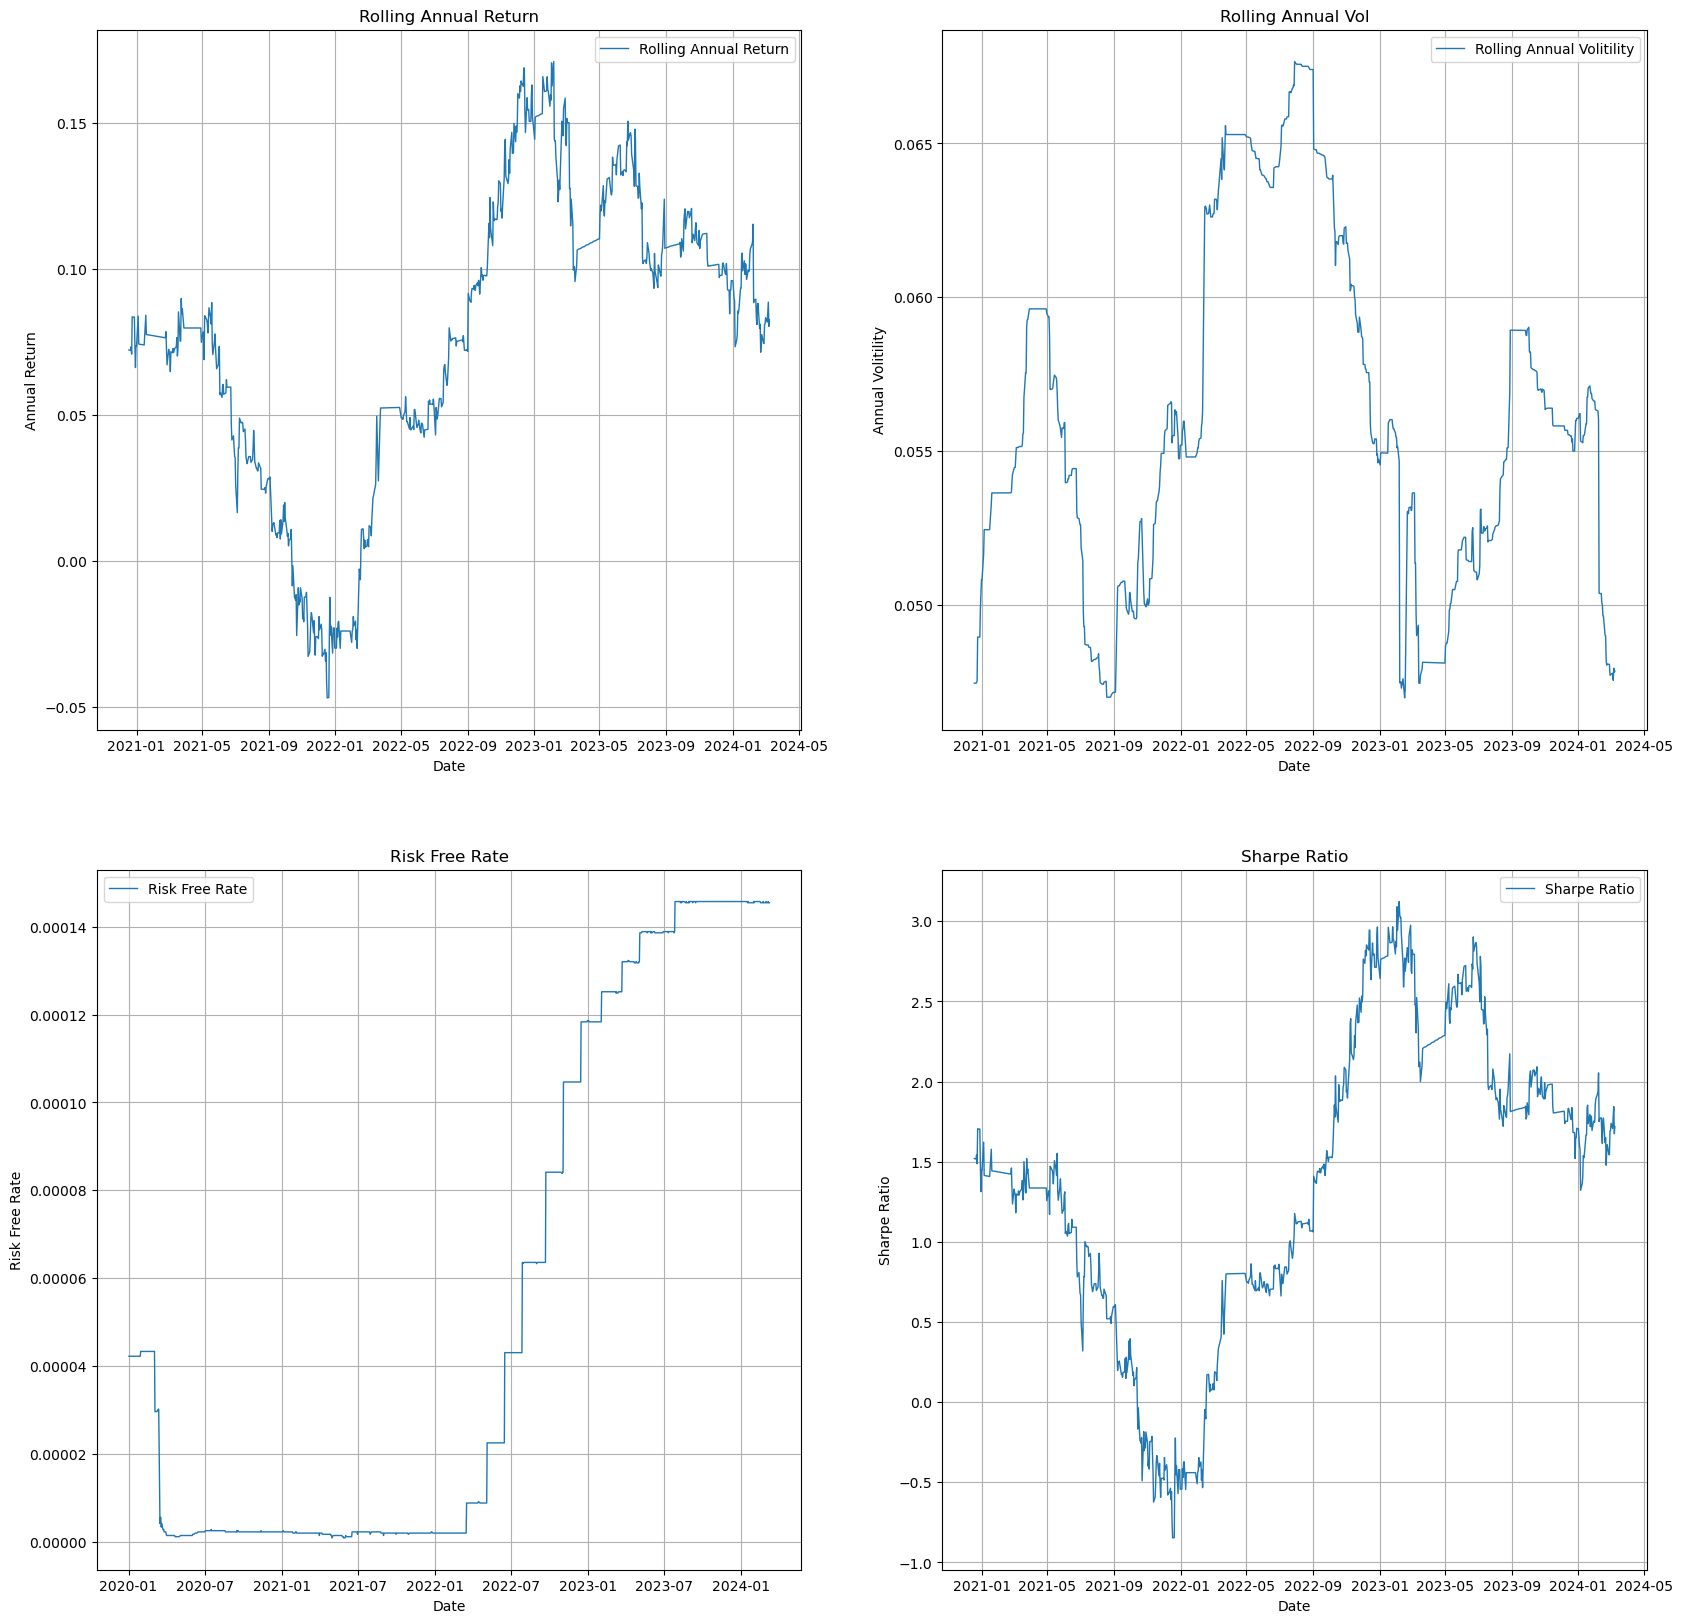

In [13]:
plt.figure(figsize=(20, 20))

plt.subplot(2,2,1)
plt.plot(daily_return_df["Dates"], daily_return_df["Rolling Annual Return"], label='Rolling Annual Return',lw = 1)
plt.title('Rolling Annual Return')
plt.xlabel('Date')
plt.ylabel('Annual Return')
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(daily_return_df["Dates"], daily_return_df["Rolling Annual Vol"], label='Rolling Annual Volitility',lw = 1)
plt.title('Rolling Annual Vol')
plt.xlabel('Date')
plt.ylabel('Annual Volitility')
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(daily_return_df["Dates"], daily_return_df["RF Rate"], label='Risk Free Rate',lw = 1)
plt.title('Risk Free Rate')
plt.xlabel('Date')
plt.ylabel('Risk Free Rate')
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(daily_return_df["Dates"], daily_return_df["Rolling Sharpe Ratio"], label='Sharpe Ratio',lw = 1)
plt.title('Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)

plt.show()

## Draw Down Plot

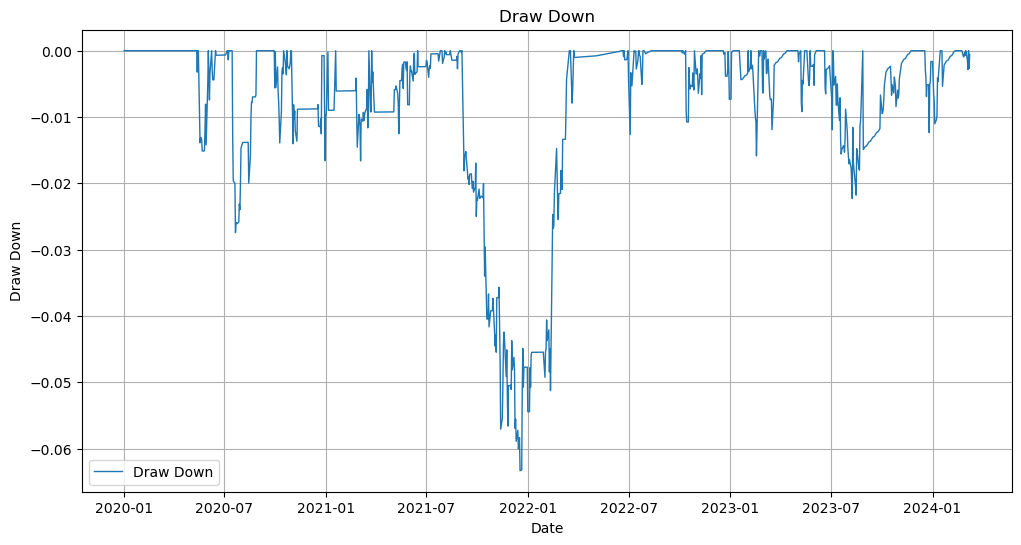

In [14]:


plt.figure(figsize=(12, 6))
plt.plot(daily_return_df["Dates"], copper_data["drawdown"], label='Draw Down',lw = 1)
plt.title('Draw Down')
plt.xlabel('Date')
plt.ylabel('Draw Down')
plt.legend()
plt.grid(True)
plt.show()

## Regression daily return on daily return of SP500 

In [15]:
import yfinance as yf
from scipy import stats

e:\Application2\Anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [16]:
# create a ticker object for the S&P 500 index
sp500 = yf.Ticker('^GSPC')

# download the historical data for the year 2020
data = sp500.history(start='2020-01-01', end='2024-03-08', interval='1d')
data_index = data.index.to_pydatetime()

In [17]:


data["Dates"] = data_index
data["Dates"] = data["Dates"].dt.date
data["Dates"] = pd.to_datetime(data["Dates"])
data = pd.DataFrame(data[["Dates","Close"]])
data = data.reset_index(drop=True)
data.columns = ["Dates","SP500"]
daily_return_df = daily_return_df.merge(data, on = "Dates",how="left")
daily_return_df["SP500_Return"] = daily_return_df["SP500"].pct_change()
regress_df = pd.DataFrame(daily_return_df[["SP500_Return","Daily Return"]])
regress_df = regress_df.dropna()

In [18]:
daily_return_df

,Dates,Daily Return,Daily Log Return,Rolling Annual Vol,Rolling Annual Return,RF Rate,Rolling Sharpe Ratio,SP500,SP500_Return
0,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-02,0.000042,0.000042,NaN,NaN,0.000042,NaN,3257.850098,NaN
2,2020-01-03,0.000042,0.000042,NaN,NaN,0.000042,NaN,3234.850098,-0.007060
3,2020-01-06,0.000042,0.000042,NaN,NaN,0.000042,NaN,3246.280029,0.003533
4,2020-01-07,0.000042,0.000042,NaN,NaN,0.000042,NaN,3237.179932,-0.002803
...,...,...,...,...,...,...,...,...,...
1079,2024-03-04,-0.001383,-0.001384,0.047769,0.081655,0.000145,1.706323,5130.950195,-0.001193
1080,2024-03-05,-0.001447,-0.001448,0.047541,0.085144,0.000146,1.787914,5078.649902,-0.010193
1081,2024-03-06,0.007931,0.007900,0.047935,0.088497,0.000145,1.843147,5104.759766,0.005141
1082,2024-03-07,-0.002688,-0.002691,0.047805,0.080205,0.000145,1.674733,5157.359863,0.010304


### Return VS SP500

In [19]:
portfolio_return = regress_df["Daily Return"]
Benchmark_return = regress_df["SP500_Return"]

(beta, alpha, r, p, se) = stats.linregress(Benchmark_return, portfolio_return)

print('The beta of your return is: ', beta)
print('The alpha of your return is: ', alpha)


The beta of your return is:  0.0016742930148648195
The alpha of your return is:  0.00029140403783776243


### Return VS Copper Price

In [20]:
portfolio_return = daily_return_df["Daily Return"].dropna()
Benchmark_return = copper_data["AVG_Price"].pct_change()[1:]

(beta, alpha, r, p, se) = stats.linregress(Benchmark_return, portfolio_return)

print('The beta of your return is: ', beta)
print('The alpha of your return is: ', alpha)

The beta of your return is:  -0.0030324119133289112
The alpha of your return is:  0.00029290748263263017


## Monthly Return

In [35]:
M_return = pd.DataFrame(daily_return_df[["Dates","Daily Return"]])
M_return["Dates"] = pd.to_datetime(M_return["Dates"])
M_return.set_index('Dates', inplace=True)

monthly_returns = M_return.resample('M').agg(lambda x: (x + 1).prod() - 1)
M_return["M_return"] = monthly_returns
#M_return.dropna(subset=['M_return'], inplace=True)
M_return.to_csv("Copper_Monthly_Return.csv")



## Heat Map

In [1]:
import seaborn as sns

In [46]:
df = pd.read_csv("Copper_Monthly_Return_Fixed.csv")
df = df.dropna()
df["Dates"] = pd.to_datetime(df["Dates"])
df["Dates"] = df["Dates"].dt.to_period('M')
df.set_index('Dates', inplace=True)
df



,M_return
Dates,
2020-01,0.000931
2020-02,0.000866
2020-03,0.000364
2020-04,0.000028
2020-05,-0.000784
2020-06,0.028124
2020-07,0.025340
2020-08,0.015288
2020-09,-0.005571


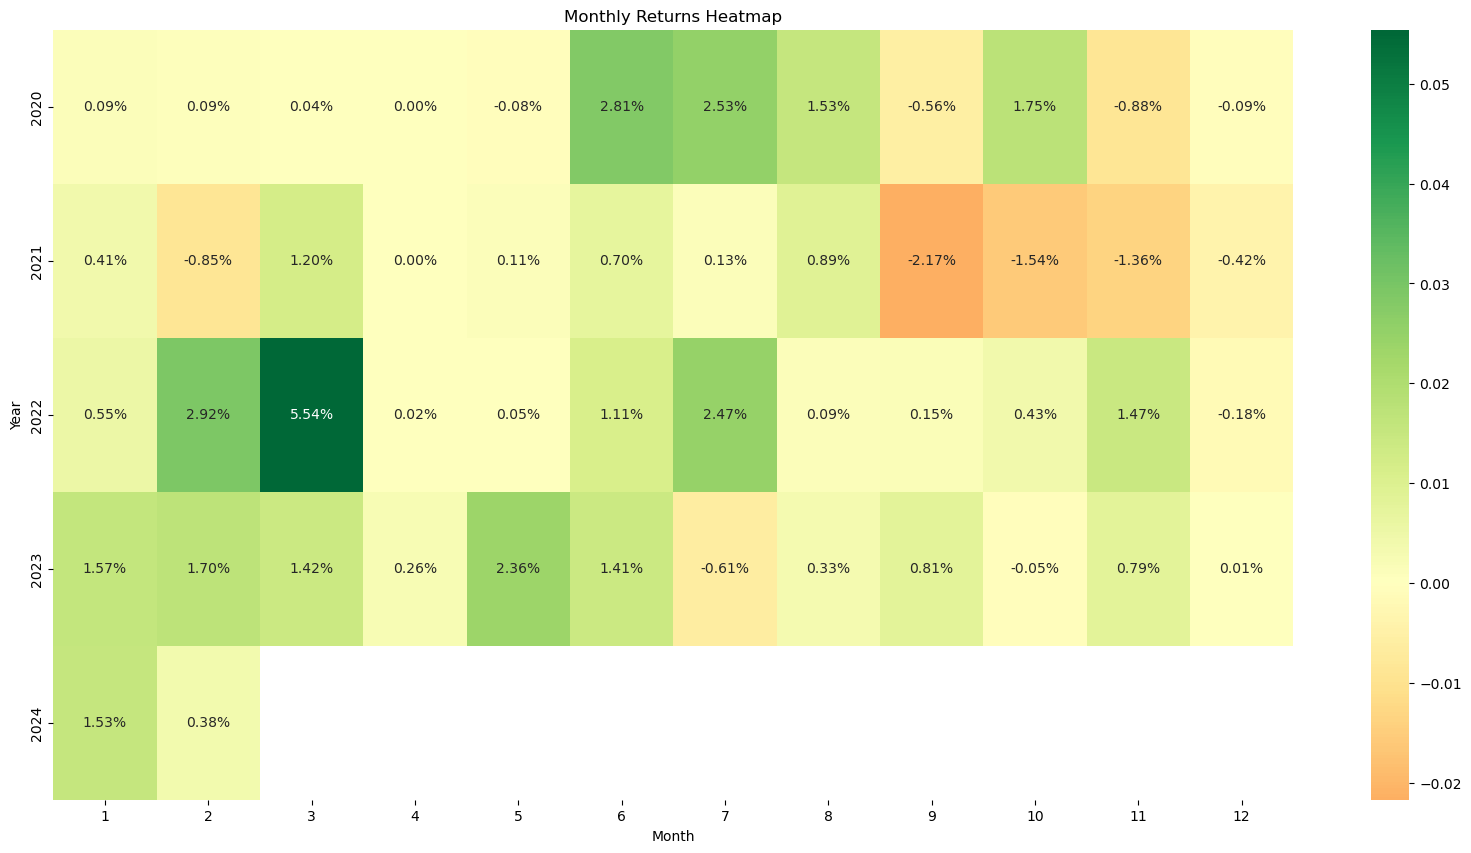

In [51]:
# Reshape the DataFrame for heatmap
heatmap_data = df.pivot_table(index=df.index.year, columns=df.index.month, values='M_return')

# Create heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, cmap='RdYlGn', center=0,annot=True, fmt=".2%")

plt.title('Monthly Returns Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

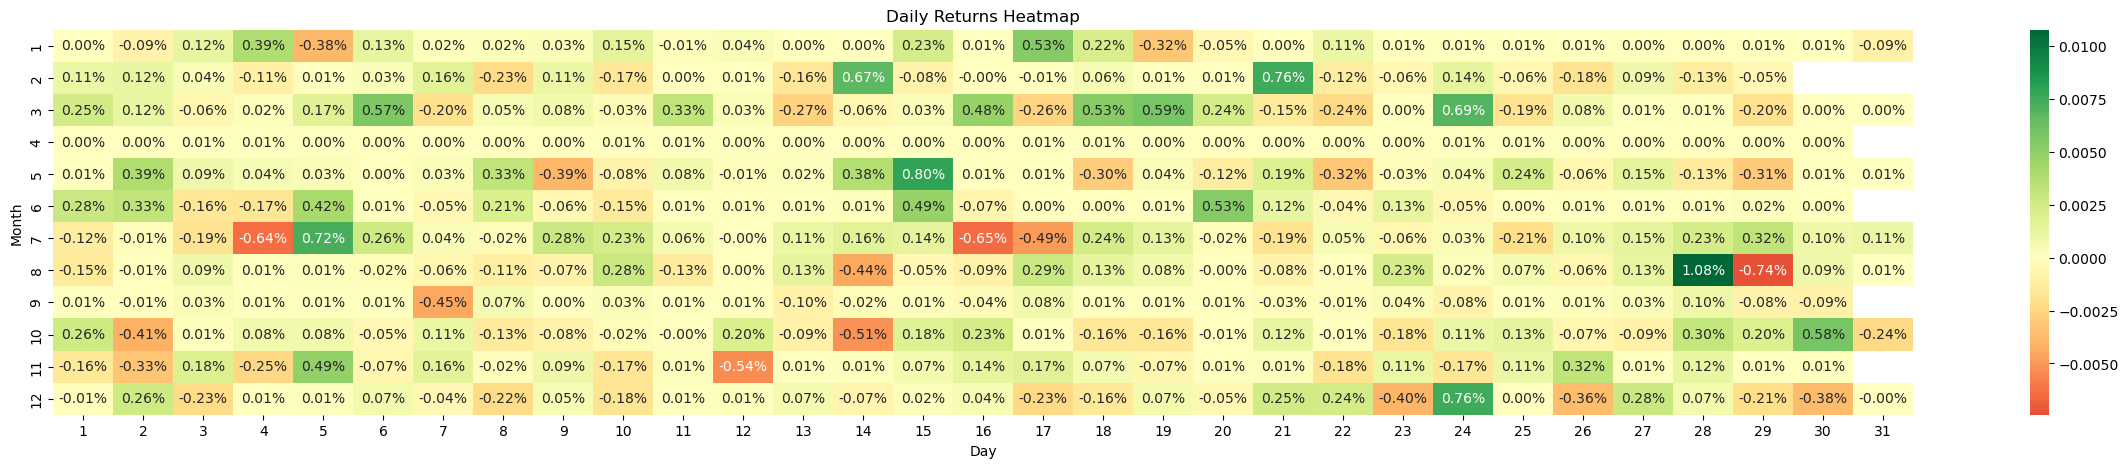

In [33]:
df = pd.DataFrame(daily_return_df[["Dates","Daily Return"]])
df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)

# Reshape the DataFrame for heatmap
heatmap_data = df.pivot_table(index=df.index.month, columns=df.index.day, values='Daily Return')

# Create heatmap
plt.figure(figsize=(30, 5))
sns.heatmap(heatmap_data, cmap='RdYlGn', center=0,annot=True, fmt=".2%")

plt.title('Daily Returns Heatmap')
plt.xlabel('Day')
plt.ylabel('Month')
plt.show()